This version simply finds all nearest neighbor tours with no further processing
- the idea is to get a rough statistical understanding of how this naive approach is affected by problem size

# TSPLIB Euclidean tours with solutions

- a280
- berlin52
- ch130
- ch150
- eil101
- eil51
- eil76
- kroA100
- kroC100
- kroD100
- lin105
- pcb442
- pr1002
- pr2392
- pr76
- rd100
- st70
- tsp225

In [15]:
import glob                               # for searching directories
import os.path                            # for checking file existence
import math                               # for distance calculations
import statistics                         # for statistics
import matplotlib.pyplot as plt           # for visual display
import sys                                # for limit values

In [16]:
def getTourNames():
    '''get names of Euclidean tours we know the exact solutions to'''
    
    # first by size, then by name
    
    return [
        'eil51',
        'berlin52',
        'st70',
        'eil76',
        'pr76',
        'kroA100',
        'kroC100',
        'kroD100',
        'rd100',
        'eil101',
        'lin105',
        'ch130',
        'ch150',
        'tsp225',
        'a280',
        'pcb442',
        'pr1002',
        'pr2392',    # this works, but takes a long time to find all nearest neighbor tours
    ]    

In [17]:
# global scope, so we don't have to worry about passing them around
# - note TSPLIB problems sets are 1-based but Python lists are 0-based

tspNodeCnt = None    # an integer: the number of nodes in a tour
tspOptTour = None    # a tuple: ( length, [nodes] )
tspNodeCoor = None   # a list: [ node, x-coor, y-coor ]

In [18]:
def waitkey():

    key = input('Press [ENTER] to continue, [Q] to quit ')
    if 'Q' != key.upper():
        print( '\n' )
    else:
        sys.exit() 


In [19]:
def euclidean(p0, p1):
    '''Euclidean distance between two points'''
    node0 = tspNodeCoor[ p0-1 ]
    node1 = tspNodeCoor[ p1-1 ]

    dx = node0[1] - node1[1]
    dy = node0[2] - node1[2]

    return round( math.sqrt( dx * dx + dy * dy ) )

def tourLength(tour):
    '''find length of tour'''
    tourlen = euclidean( tour[0], tour[-1] )             # distance between first and last points
    for node in range(1, len(tour)):                     # ...plus all the rest of the points
        tourlen += euclidean( tour[node-1], tour[node] )
    return tourlen
    

In [20]:
# functions and variables related to displays

def getDisplayCoor(tour):
    '''make sequences of X and Y coordinates for display'''
     
    xpts = []
    ypts = []
    
    for node in tour:
        nn, xc, yc = tspNodeCoor[ node-1 ]
        xpts.append( xc )          # x-coordinate
        ypts.append (yc )          # y-coordinate
        
    xpts.append( xpts[0] )         # last node == first node
    ypts.append( ypts[0] )
    
    return ( xpts, ypts )

def getOptCoor():
    '''get display coordinates for problem set nodes'''
    # the nodes of the problem set (in monotonic order)
    xnodes, ynodes = getDisplayCoor( range(1, len(tspOptTour[1])+1) )
    # the nodes of the optimal tour (in optimal order)
    xopts, yopts = getDisplayCoor( tspOptTour[1] )
    return [ xnodes, ynodes, xopts, yopts ]

def displayOptTour(name):
    '''display the optimal tour'''
    # get display coordinates
    xnodes, ynodes, xopt, yopts = getOptCoor()
    # show tour
    plt.figure( figsize=(12,10), dpi=109 )
    plt.title( name )
    plt.scatter( xnodes, ynodes )
    plt.plot( xopts, yopts, c='r' )
    plt.show() 
    
def tourDiff(foundlen, optlen):
    '''percentage difference in found tour to optimal tour'''
    diff = ( foundlen / optlen ) * 100
    return f'{round(diff, 1)}%'


In [21]:
# display min, max and optimal tours

def displayTours(name, mintour, maxtour, opttour):
    '''display min, max and optimal tours'''
    # get display coordinates
    xnodes, ynodes, xopts, yopts = getOptCoor()
    xmins, ymins = getDisplayCoor( mintour )
    xmaxs, ymaxs = getDisplayCoor( maxtour )
    # show them
    plt.figure( figsize=(12,10), dpi=109 )
    plt.title( name )
    plt.scatter( xnodes, ynodes )
    # these are on top of each other
    plt.plot( xmaxs, ymaxs, c='b' )
    plt.plot( xmins, ymins, c='g' )
    plt.plot( xopts, yopts, c='r' )
    plt.show()
    

In [22]:
def showlens(tours):
    '''display lengths of all tours'''
    
    # dictionary key = tour length
    # dictionary value = first node in every tour with that length

    lengths = dict()
    for tour in tours:
        if not tour[0] in lengths:
            lengths[ tour[0] ] = []
        lengths[tour[0]].append( tour[1][0] )
        
    # show the dictionary
    # - the idea is to see where tour reduction "stalled out"
    # - which might give us some ideas of what to do about that
    
    for length in lengths:
        samelength = lengths[ length ]
        print( f"{len(samelength)} tours of length {length: 6}:\t{samelength}" )

    print( f"\n{len(tours): 5} tours of {len(lengths)} different lengths" )


In [23]:
def showTours(name, tours):
    
    mintomax = sorted( tours, key=lambda x: x[0] )
    mintour = mintomax[ 0 ]
    maxtour = mintomax[ -1 ]
    minlen = mintour[ 0 ]
    maxlen = maxtour[ 0 ]
    optlen = tspOptTour[ 0 ]
    
    displayTours( name, mintour[1], maxtour[1], tspOptTour[1] )
    
    # some statistics regarding this tour

    print( f'(red)   Optimal  Tour: {optlen: 6}   {tourDiff(optlen, optlen)}')
    print( f'(grn) Minimum NN Tour: {minlen: 6}   {tourDiff(minlen, optlen)}')
    print( f'(blu) Maximum NN Tour: {maxlen: 6}   {tourDiff(maxlen, optlen)}\n')
    
    avelen = round( statistics.mean([elem[0] for elem in mintomax]) )
    print( f'  Average Tour Length: {avelen: 6}   {tourDiff(avelen, optlen)}\n' )
    
    showlens( mintomax )

In [24]:
def loadTour(directory, probname):
    '''read and setup one tour problem and its solution'''
    global tspNodeCnt, tspNodeCoor, tspOptTour

    tspNodeCnt = tspOptTour = tspNodeCoor = None

    # the solution (if there is a solution set, there is a problem set - but the reverse is not always true)

    solution = f'{directory}\\{probname}.opt.tour'
    if os.path.isfile(solution):
        with open(solution) as f:
            tsp_data = f.readlines()
    else:
        return False
        
    opttour = []
    collecting = False
    for line in tsp_data:
        if not collecting:
            collecting = line.find('TOUR_SECT') > -1
 
        elif line.find('EOF') < 0:
            nodes = line.split()                     # sometimes multiple nodes are on one line
            for node in nodes:
                i = int( node )
                if i > 0:                            # negative one signifies end of nodes
                    opttour.append( i )
    
    # the associated problem (we want only nice Euclidean 2D problems, BTW)
    
    problem = f'{directory}\\{probname}.tsp'
    if os.path.isfile(problem):
        with open(problem) as f:
            tsp_data = f.readlines()
    else:
        return False
        
    nodes = []
    collecting = False
    for line in tsp_data:
        if not collecting:
            collecting = line.find('NODE_COORD_SECTION') > -1

        # annoyingly enough, some of these files end in chr('0x0A'), not the string 'EOF'
        elif ord(line[0]) > 20 and line.find('EOF') < 0:
            words = line.split()
            # 'x.0' floats are a nuisance
            nodes.append( [int(words[0]), float(words[1]), float(words[2]) ] )

    # how many nodes in this tour
    tspNodeCnt = len( nodes )
            
    # a list of [ node, x-coor, y-coor ]
    tspNodeCoor = nodes

    # a tuple of ( length, [nodes] )
    tspOptTour = ( tourLength(opttour), opttour )

    return True
   

In [25]:
def perturb(tour, ndxnode1, ndxnode2):
    '''find the greatest reduction in tour size'''
            
    # find the indices of the nodes affected by any change we propose to try
    
    ndxpred1 = ndxnode1-1 if ndxnode1 > 1 else tspNodeCnt
    ndxsucc1 = ndxnode1+1 if ndxnode1 < tspNodeCnt else 1
    
    ndxpred2 = ndxnode2-1 if ndxnode2 > 1 else tspNodeCnt
    ndxsucc2 = ndxnode2+1 if ndxnode2 < tspNodeCnt else 1
    
    # find the nodes at those indices
    
    pred1 = tour[1][ndxpred1-1]
    node1 = tour[1][ndxnode1-1]
    succ1 = tour[1][ndxsucc1-1]
    
    pred2 = tour[1][ndxpred2-1]
    node2 = tour[1][ndxnode2-1]
    succ2 = tour[1][ndxsucc2-1]
    
    # assume no change results in a shorter tour
    
    maxdelta = 0
    
    # try reversing the order of the nodes:
    # pred1 - node1 succ1 ... pred2 node2 - succ2 ->
    # pred1 + node2 pred2 ... succ1 node1 + succ2
    
    # how long are the two edges we're going to break ?
    
    p1n1 = euclidean( pred1, node1 )
    n2s2 = euclidean( node2, succ2 )
    orglen = p1n1 + n2s2
    
    # how long are the two edges we're going to make ?
    
    p1n2 = euclidean( pred1, node2 )
    n1s2 = euclidean( node1, succ2 )
    newlen = p1n2 + n1s2
    
    # does this make the tour shorter ?
    
    delta = newlen - orglen
    if delta < maxdelta:
        changetype = "reverse"
        maxdelta = delta

    # if the two nodes are adjacent, all changes we might make are equivalent
    # - otherwise, we want to try three more possibilities
    
    if succ1 != node2:
    
        # try rotating the node string one position left:
        # pred1 - node1 - succ1 ... pred2 node2 - succ2 ->
        # pred1 + succ1 ... pred2 node2 + node1 + succ2

        n1s1 = euclidean( node1, succ1 )
        orglen = p1n1 + n1s1 + n2s2

        p1s1 = euclidean( pred1, succ1 )
        n2n1 = euclidean( node2, node1 )
        newlen = p1s1 + n2n1 + n1s2

        delta = newlen - orglen
        if delta < maxdelta:
            changetype = "rotleft"
            maxdelta = delta

        # try rotating the node string one position right:
        # pred1 - node1 succ1 ... pred2 - node2 - succ2 ->
        # pred1 + node2 + node1 succ1 ... pred2 + succ2

        p2n2 = euclidean( pred2, node2 )
        orglen = p1n1 + p2n2 + n2s2

        p2s2 = euclidean( pred2, succ2 )
        newlen = p1n2 + n2n1 + p2s2

        delta = newlen - orglen
        if delta < maxdelta:
            changetype = "rotright"
            maxdelta = delta

        # try exchanging node1 and node2
        # pred1 - node1 - succ1 ... pred2 - node2 - succ2 ->
        # pred1 + node2 + succ1 ... pred2 + node1 + succ2

        orglen = p1n1 + n1s1 + p2n2 + n2s2

        n2s1 = euclidean( node2, succ1 )
        p2n1 = euclidean( pred2, node1 )
        newlen = p1n2 + n2s1 + p2n1 + n1s2

        delta = newlen - orglen
        if delta < maxdelta:
            changetype = "exchange"
            maxdelta = delta
            
    # make sure no aliasing happens

    bestlen = tour[0]
    besttour = tour[1].copy()
    
    # did any change make a difference ?
    
    if maxdelta < 0:

#        print( f"{changetype} with nodes at indices {ndxnode1} and {ndxnode2} reduces size by {maxdelta}" )
    
        # account for the zero-based list

        node1 = ndxnode1 - 1
        node2 = ndxnode2 - 1
        
        # make the change

        if changetype == "reverse":
            while node1 < node2:
                besttour[node1], besttour[node2] = besttour[node2], besttour[node1]
                node1 += 1
                node2 -= 1

        elif changetype == "rotleft":
            temp = besttour[ node1 ]
            for k in range(node1, node2):
                besttour[ k ] = besttour[ k+1 ]
            besttour[ node2 ] = temp

        elif changetype == "rotright":
            temp = besttour[ node2 ]
            for k in range(node2, node1, -1):
                besttour[ k ] = besttour[ k-1 ]
            besttour[ node1 ] = temp

        elif changetype == "exchange":
            besttour[node1], besttour[node2] = besttour[node2], besttour[node1]

        else:
            error( "unrecognized changetype")
        
        bestlen = tourLength( besttour )
        
#        print( f"Best Tour - {bestlen}" )
#        print( f"{besttour}\n" )
                
    return ( bestlen, besttour )

def perturbOneTour(this):
    
    # kickstart the loop
    
    shorter = True
    
    # keep looping every time we find a shorter tour

    while ( shorter ):
        startlen = this[ 0 ]
        for i in range(2, tspNodeCnt):
            for j in range(i+1, tspNodeCnt+1):
                newtour = perturb( this, i, j )
                if newtour[0] < this[0]:
                    this = ( newtour[0], newtour[1].copy() )
                elif newtour[0] > this[0]:
                    error( f"Should not happen: {newtour[0]} > {this[0]}" )
                    assert( False )
    
        shorter = ( this[0] < startlen )
    
    return this
 
def perturbAllTours(these):
    
    perturbed = []
    
    for tour in these:
        newtour = perturbOneTour( tour )
        perturbed.append( newtour )
    
    return perturbed


In [26]:
# create all nearest neighbor tours

def findNearest(thisnode, remainingnodes):
    '''find the closest remaining node to this node'''
    # - if more than one have the same distance, returns the first one found
    mindist = sys.maxsize
    minnode = 0
    
    node0 = tspNodeCoor[ thisnode-1 ]
    xpos0 = node0[ 1 ]
    ypos0 = node0[ 2 ]
 
    for node in remainingnodes:

        node1 = tspNodeCoor[ node-1 ]

        dx = xpos0 - node1[1]
        if abs(dx) >= mindist:
            continue
 
        dy = ypos0 - node1[2]
        if abs(dy) >= mindist:
            continue

        delta = round( math.sqrt(dx * dx + dy * dy) )
        if delta < mindist:
            mindist = delta
            minnode = node
            
    return minnode
    
def oneNNtour(startnode):
    '''create one nearest neighbor tour'''
    unvisited = set( tspOptTour[1] ) - { startnode }
    
    tour = [ startnode ]
    
    # find the nearest remaining point to the one we just added
    while unvisited:
        nearest = findNearest( tour[-1], unvisited )
        unvisited.remove( nearest )
        tour.append( nearest )
        
    return ( tourLength(tour), tour )
    
def allNNtours():
    '''create all nearest neighbor tours'''
    alltours = []
    
    for node in range(1, tspNodeCnt+1):
        alltours.append( oneNNtour(node) )

    return alltours

In [27]:
# show one nearest neighbor tour

def perturbOneNN(probdir, probname):
    '''show and perturb one nearest neighbor tour'''
    
    print( f'\n{probname}' )

    if loadTour(probdir, probname):
        print( 'Loaded' )
        # all nearest neighbor tours
        alltours = allNNtours()
        showTours( probname, alltours )
        # perturb each one
#        perturbed = perturbAllTours( alltours )
#        showTours( probname, perturbed )

    else:
        print( 'NOT Loaded' )

def showAllNN(probdir):
    
    tours = getTourNames()
    for tour in tours:
        perturbOneNN( probdir, tour )


Started


eil51
Loaded


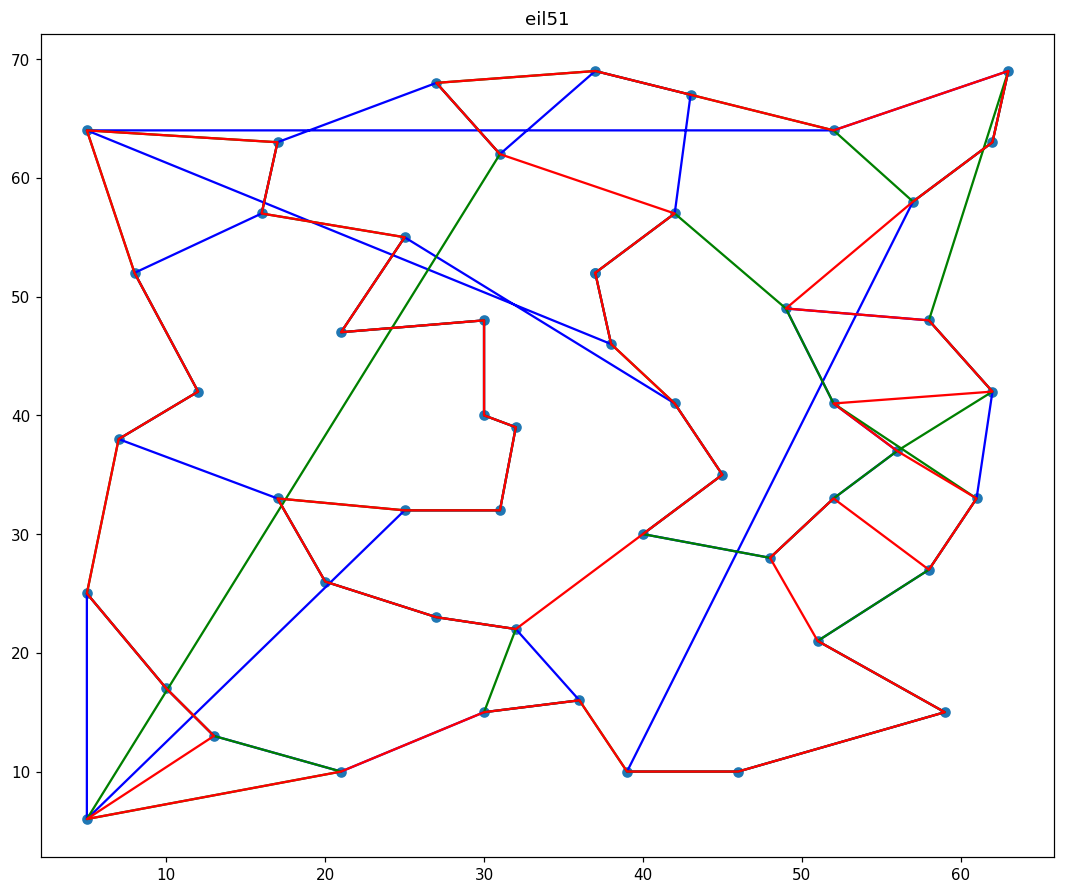

(red)   Optimal  Tour:    426   100.0%
(grn) Minimum NN Tour:    482   113.1%
(blu) Maximum NN Tour:    563   132.2%

  Average Tour Length:    526   123.5%

1 tours of length    482:	[8]
1 tours of length    483:	[24]
2 tours of length    485:	[23, 26]
4 tours of length    495:	[19, 25, 40, 42]
1 tours of length    496:	[31]
1 tours of length    503:	[47]
1 tours of length    505:	[37]
3 tours of length    507:	[6, 41, 48]
1 tours of length    508:	[13]
2 tours of length    509:	[27, 44]
1 tours of length    511:	[1]
3 tours of length    512:	[7, 14, 43]
1 tours of length    515:	[15]
1 tours of length    518:	[22]
1 tours of length    523:	[45]
1 tours of length    529:	[2]
2 tours of length    530:	[18, 38]
1 tours of length    531:	[4]
1 tours of length    534:	[17]
1 tours of length    536:	[33]
2 tours of length    541:	[9, 39]
1 tours of length    542:	[21]
1 tours of length    543:	[29]
3 tours of length    544:	[5, 16, 35]
1 tours of length    546:	[30]
1 tours of length    54

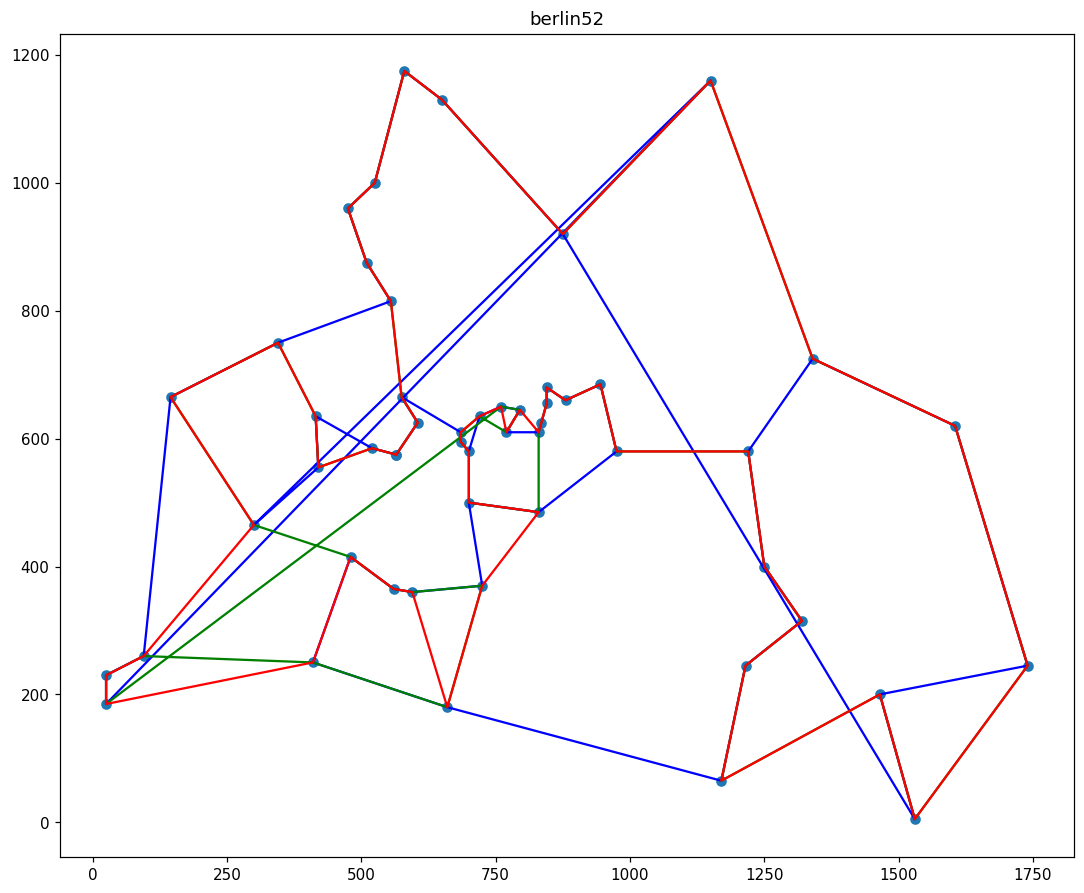

(red)   Optimal  Tour:   7542   100.0%
(grn) Minimum NN Tour:   8181   108.5%
(blu) Maximum NN Tour:  10298   136.5%

  Average Tour Length:   9376   124.3%

1 tours of length   8181:	[40]
1 tours of length   8206:	[38]
1 tours of length   8848:	[23]
2 tours of length   8864:	[30, 42]
1 tours of length   8920:	[22]
1 tours of length   8953:	[31]
1 tours of length   8980:	[1]
1 tours of length   8995:	[18]
1 tours of length   9013:	[37]
1 tours of length   9067:	[48]
1 tours of length   9073:	[44]
1 tours of length   9091:	[32]
1 tours of length   9098:	[24]
1 tours of length   9112:	[10]
1 tours of length   9123:	[49]
1 tours of length   9137:	[34]
1 tours of length   9156:	[36]
1 tours of length   9161:	[35]
1 tours of length   9192:	[9]
1 tours of length   9214:	[39]
1 tours of length   9220:	[19]
1 tours of length   9251:	[50]
1 tours of length   9252:	[20]
1 tours of length   9257:	[46]
1 tours of length   9290:	[5]
1 tours of length   9304:	[28]
1 tours of length   9317:	[6]
1 tou

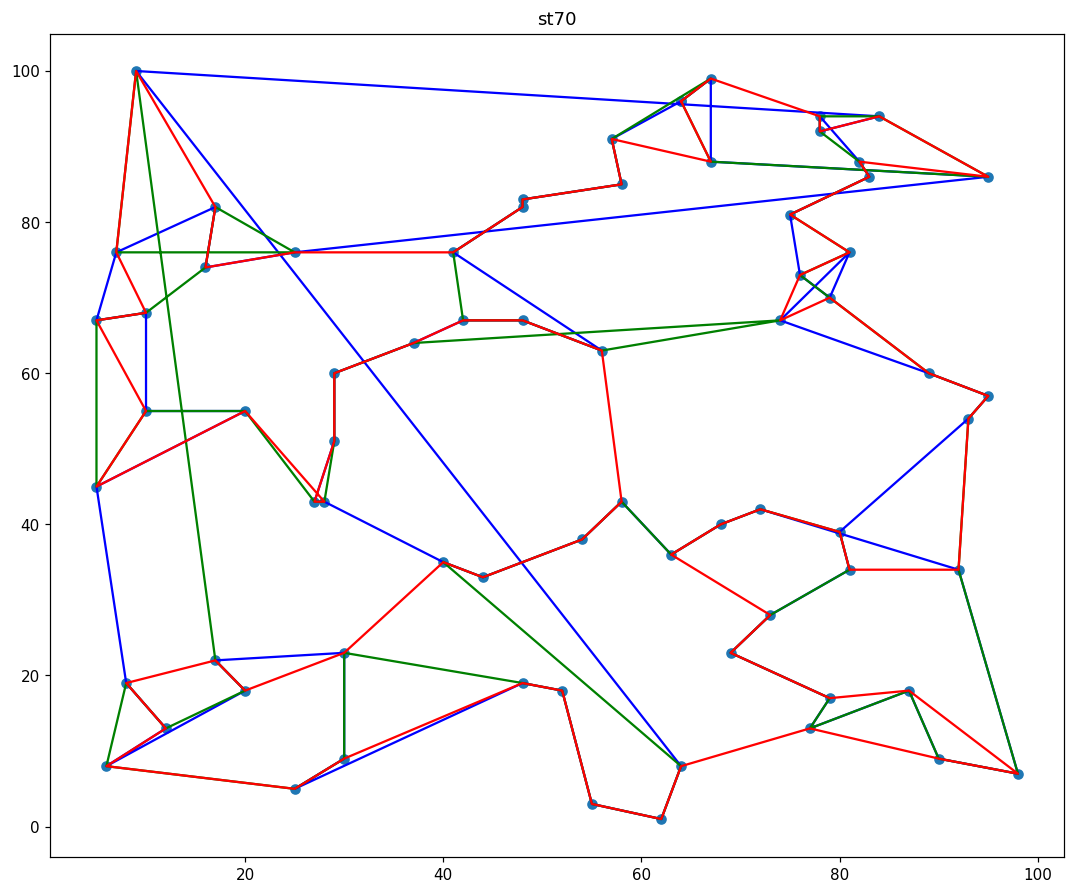

(red)   Optimal  Tour:    675   100.0%
(grn) Minimum NN Tour:    796   117.9%
(blu) Maximum NN Tour:    911   135.0%

  Average Tour Length:    841   124.6%

1 tours of length    796:	[17]
2 tours of length    803:	[21, 34]
1 tours of length    808:	[41]
1 tours of length    809:	[60]
1 tours of length    810:	[27]
2 tours of length    811:	[11, 48]
1 tours of length    812:	[40]
2 tours of length    814:	[6, 46]
3 tours of length    815:	[9, 64, 65]
2 tours of length    819:	[52, 61]
1 tours of length    820:	[67]
1 tours of length    821:	[4]
1 tours of length    823:	[43]
2 tours of length    825:	[12, 39]
1 tours of length    826:	[25]
1 tours of length    827:	[5]
1 tours of length    828:	[62]
1 tours of length    829:	[30]
2 tours of length    830:	[1, 68]
2 tours of length    831:	[28, 53]
3 tours of length    832:	[19, 50, 51]
1 tours of length    833:	[8]
1 tours of length    835:	[37]
1 tours of length    838:	[33]
1 tours of length    839:	[26]
2 tours of length    840:	[3,

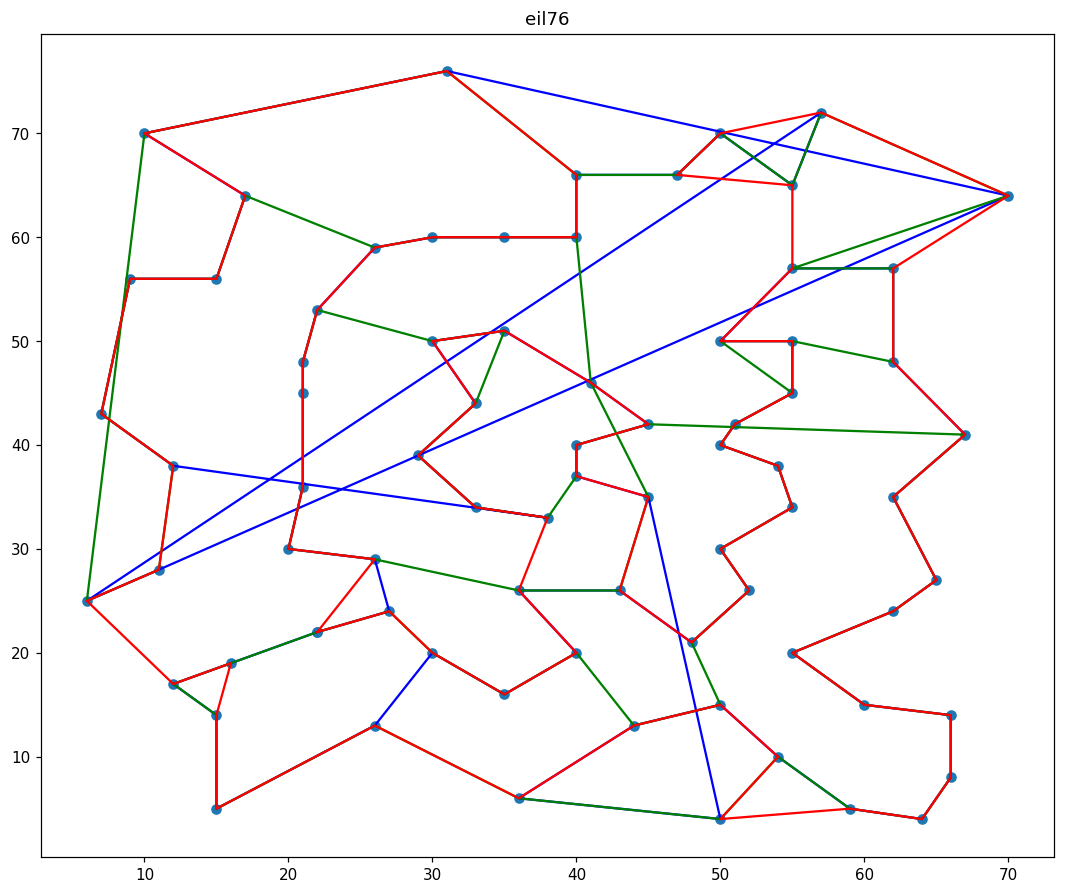

(red)   Optimal  Tour:    538   100.0%
(grn) Minimum NN Tour:    608   113.0%
(blu) Maximum NN Tour:    710   132.0%

  Average Tour Length:    666   123.8%

1 tours of length    608:	[53]
1 tours of length    612:	[52]
1 tours of length    614:	[46]
1 tours of length    618:	[33]
3 tours of length    630:	[24, 67, 76]
1 tours of length    631:	[34]
1 tours of length    632:	[45]
1 tours of length    634:	[17]
1 tours of length    636:	[75]
2 tours of length    637:	[4, 38]
1 tours of length    639:	[42]
1 tours of length    640:	[64]
1 tours of length    641:	[68]
3 tours of length    642:	[1, 6, 41]
1 tours of length    646:	[51]
1 tours of length    647:	[40]
1 tours of length    648:	[63]
1 tours of length    650:	[28]
2 tours of length    651:	[12, 16]
1 tours of length    654:	[23]
1 tours of length    655:	[74]
2 tours of length    656:	[25, 26]
1 tours of length    657:	[55]
1 tours of length    659:	[3]
2 tours of length    660:	[56, 73]
2 tours of length    661:	[2, 32]
1 tou

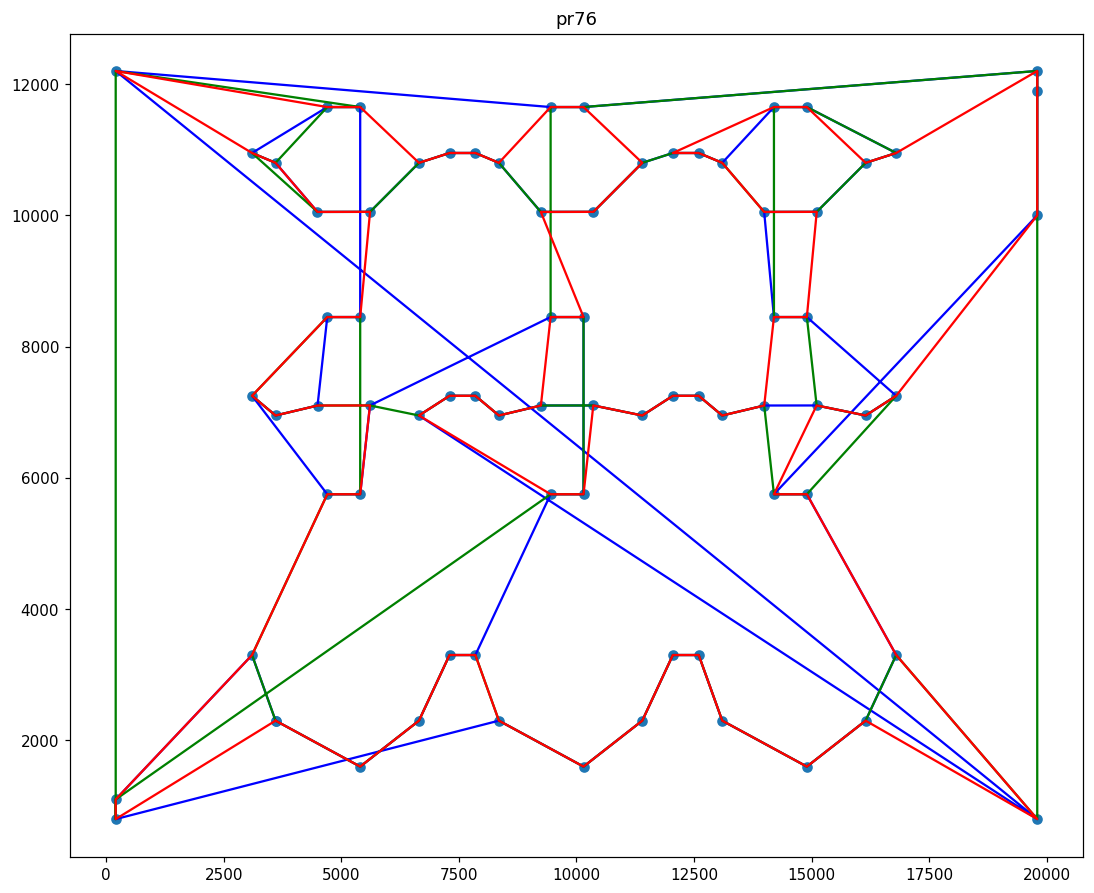

(red)   Optimal  Tour:  108159   100.0%
(grn) Minimum NN Tour:  130921   121.0%
(blu) Maximum NN Tour:  157073   145.2%

  Average Tour Length:  147178   136.1%

1 tours of length  130921:	[16]
1 tours of length  131607:	[11]
1 tours of length  132174:	[15]
1 tours of length  133895:	[12]
1 tours of length  134394:	[32]
1 tours of length  134686:	[43]
1 tours of length  135240:	[74]
1 tours of length  135401:	[14]
1 tours of length  135900:	[13]
1 tours of length  137132:	[30]
1 tours of length  137933:	[33]
1 tours of length  138644:	[36]
1 tours of length  139635:	[37]
1 tours of length  140474:	[38]
1 tours of length  141100:	[29]
1 tours of length  141588:	[27]
1 tours of length  142172:	[26]
1 tours of length  142392:	[10]
1 tours of length  142460:	[35]
1 tours of length  142610:	[31]
1 tours of length  142881:	[42]
1 tours of length  143096:	[4]
1 tours of length  143812:	[39]
1 tours of length  145678:	[40]
1 tours of length  145822:	[34]
1 tours of length  145859:	[49]
1 tours

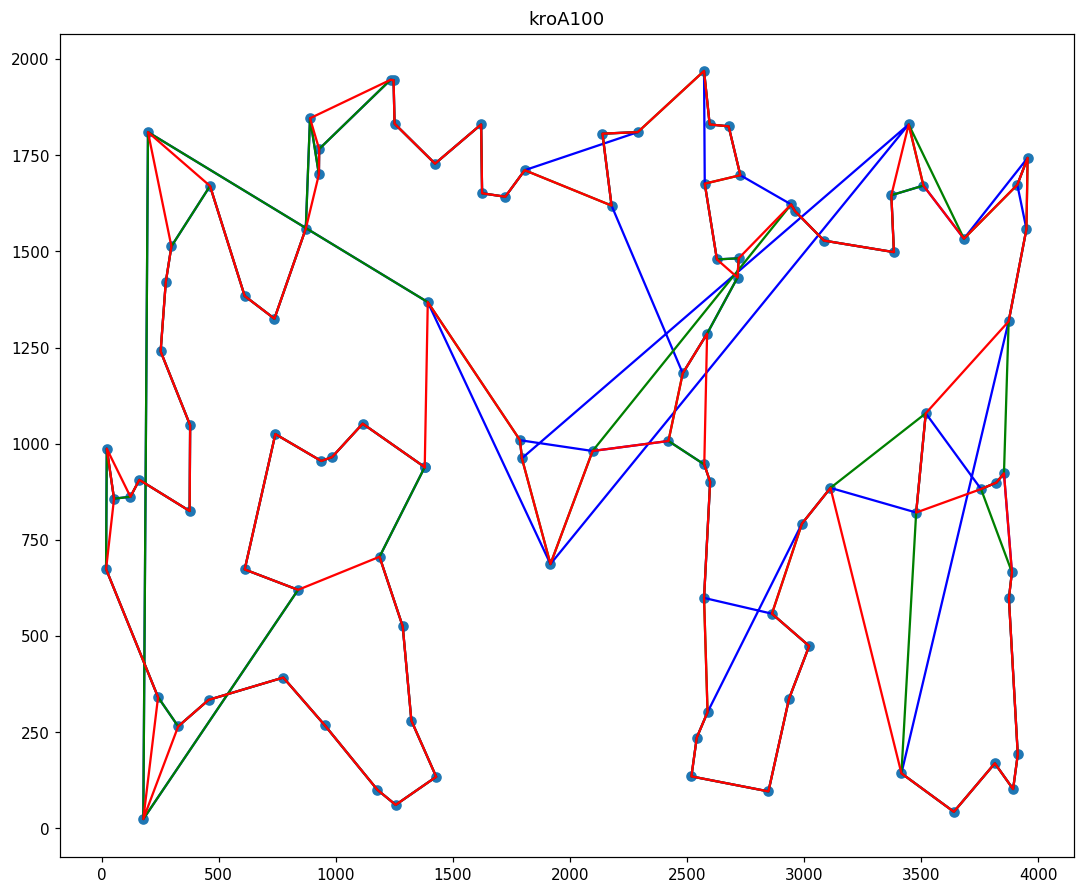

(red)   Optimal  Tour:  21282   100.0%
(grn) Minimum NN Tour:  24698   116.1%
(blu) Maximum NN Tour:  28692   134.8%

  Average Tour Length:  27046   127.1%

1 tours of length  24698:	[85]
1 tours of length  25420:	[50]
1 tours of length  25525:	[44]
1 tours of length  25647:	[30]
1 tours of length  25760:	[68]
1 tours of length  25778:	[58]
1 tours of length  25878:	[39]
1 tours of length  25943:	[51]
1 tours of length  26131:	[54]
1 tours of length  26133:	[2]
1 tours of length  26155:	[64]
1 tours of length  26207:	[81]
1 tours of length  26224:	[41]
1 tours of length  26233:	[25]
1 tours of length  26259:	[66]
1 tours of length  26263:	[71]
2 tours of length  26288:	[26, 65]
1 tours of length  26309:	[40]
1 tours of length  26326:	[73]
1 tours of length  26355:	[20]
1 tours of length  26427:	[94]
1 tours of length  26432:	[48]
1 tours of length  26462:	[97]
1 tours of length  26466:	[34]
2 tours of length  26478:	[4, 70]
1 tours of length  26484:	[45]
1 tours of length  26486:	[53]

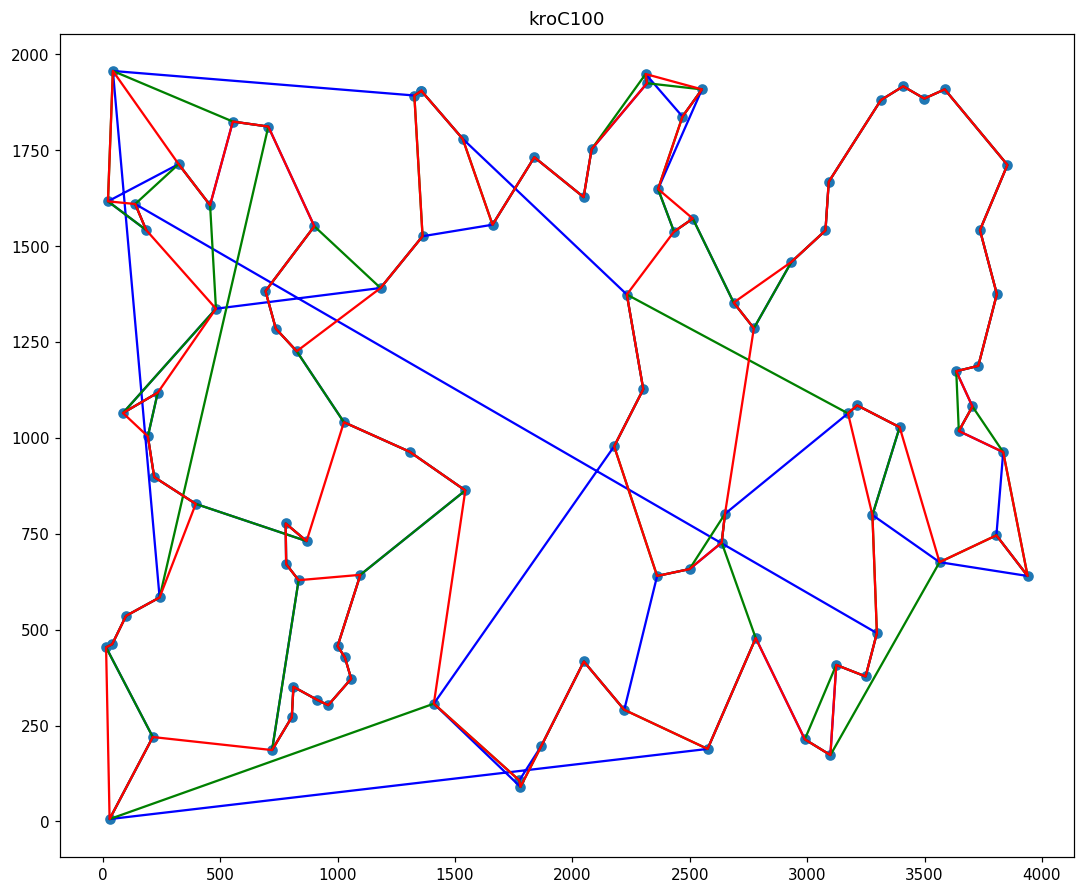

(red)   Optimal  Tour:  20749   100.0%
(grn) Minimum NN Tour:  23660   114.0%
(blu) Maximum NN Tour:  29488   142.1%

  Average Tour Length:  26181   126.2%

4 tours of length  23660:	[5, 38, 56, 86]
1 tours of length  23665:	[43]
1 tours of length  23695:	[71]
1 tours of length  24247:	[47]
1 tours of length  24268:	[77]
1 tours of length  24286:	[31]
1 tours of length  24362:	[83]
1 tours of length  24364:	[62]
1 tours of length  24432:	[67]
1 tours of length  24546:	[88]
1 tours of length  24551:	[42]
1 tours of length  24572:	[55]
1 tours of length  24779:	[13]
1 tours of length  24852:	[79]
1 tours of length  24891:	[75]
1 tours of length  24901:	[10]
1 tours of length  24954:	[33]
1 tours of length  25060:	[99]
1 tours of length  25064:	[92]
2 tours of length  25108:	[48, 97]
2 tours of length  25140:	[51, 63]
1 tours of length  25157:	[19]
1 tours of length  25194:	[60]
1 tours of length  25259:	[16]
1 tours of length  25280:	[44]
1 tours of length  25317:	[45]
1 tours of length

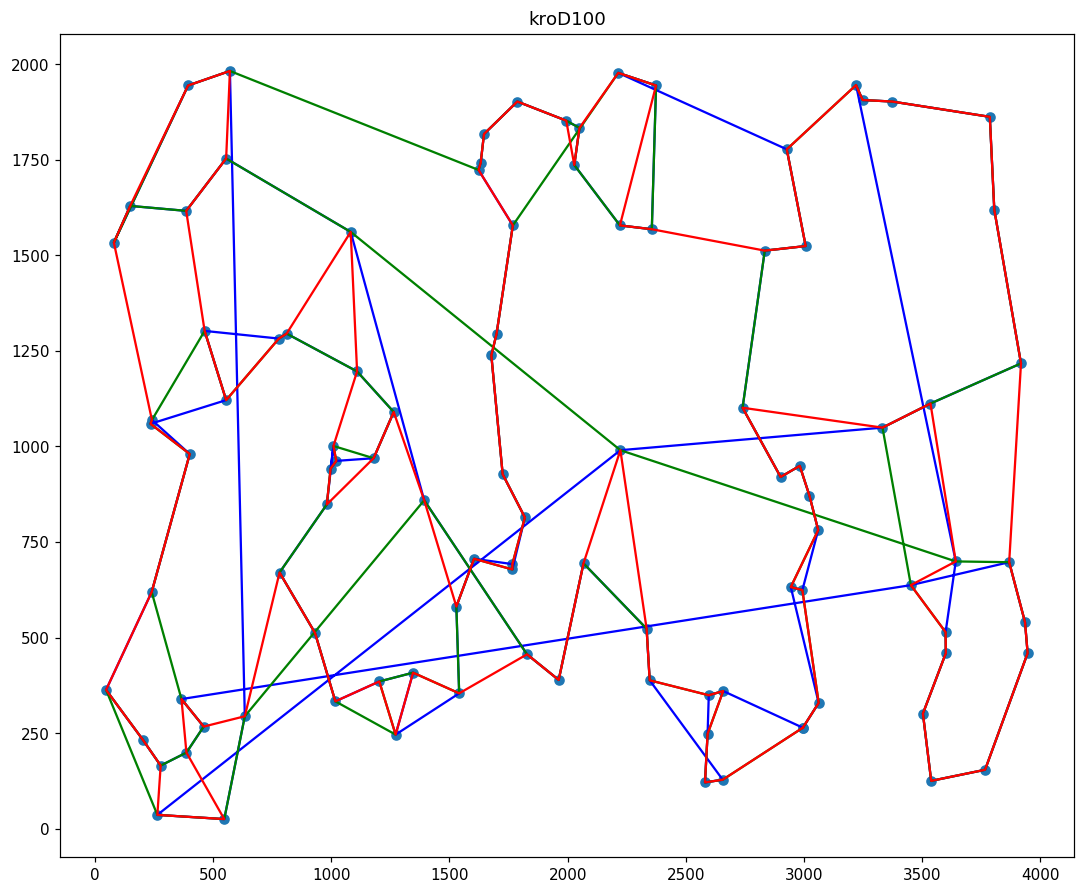

(red)   Optimal  Tour:  21294   100.0%
(grn) Minimum NN Tour:  24852   116.7%
(blu) Maximum NN Tour:  29921   140.5%

  Average Tour Length:  27469   129.0%

1 tours of length  24852:	[14]
1 tours of length  24878:	[68]
1 tours of length  25026:	[99]
1 tours of length  25039:	[45]
1 tours of length  25105:	[31]
1 tours of length  25123:	[78]
1 tours of length  25137:	[33]
1 tours of length  25248:	[84]
1 tours of length  25300:	[41]
1 tours of length  25407:	[86]
1 tours of length  25707:	[77]
1 tours of length  25715:	[80]
1 tours of length  25728:	[76]
1 tours of length  26382:	[81]
1 tours of length  26390:	[8]
1 tours of length  26397:	[66]
1 tours of length  26414:	[52]
1 tours of length  26447:	[34]
1 tours of length  26457:	[11]
1 tours of length  26507:	[23]
1 tours of length  26535:	[38]
1 tours of length  26561:	[69]
1 tours of length  26583:	[24]
1 tours of length  26595:	[27]
1 tours of length  26679:	[46]
1 tours of length  26894:	[7]
1 tours of length  26912:	[42]
1 tours

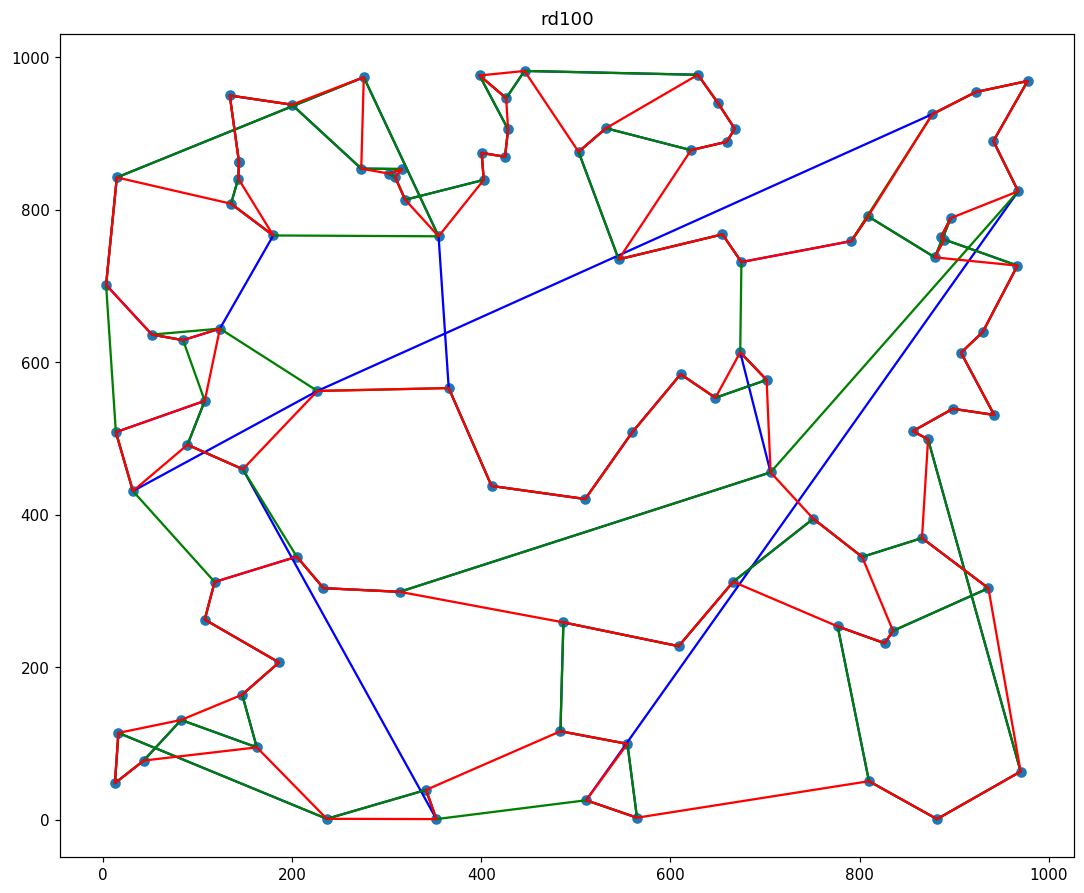

(red)   Optimal  Tour:   7910   100.0%
(grn) Minimum NN Tour:   9423   119.1%
(blu) Maximum NN Tour:  10772   136.2%

  Average Tour Length:  10110   127.8%

1 tours of length   9423:	[81]
1 tours of length   9502:	[36]
1 tours of length   9515:	[90]
1 tours of length   9548:	[78]
2 tours of length   9587:	[20, 64]
1 tours of length   9598:	[74]
1 tours of length   9618:	[9]
1 tours of length   9669:	[45]
1 tours of length   9707:	[13]
1 tours of length   9727:	[65]
1 tours of length   9769:	[7]
1 tours of length   9776:	[94]
1 tours of length   9799:	[32]
1 tours of length   9842:	[40]
1 tours of length   9847:	[44]
2 tours of length   9850:	[57, 67]
1 tours of length   9857:	[49]
1 tours of length   9858:	[100]
1 tours of length   9861:	[21]
1 tours of length   9868:	[4]
1 tours of length   9879:	[39]
1 tours of length   9884:	[43]
1 tours of length   9889:	[42]
1 tours of length   9893:	[6]
1 tours of length   9896:	[19]
1 tours of length   9897:	[69]
1 tours of length   9902:	[10]


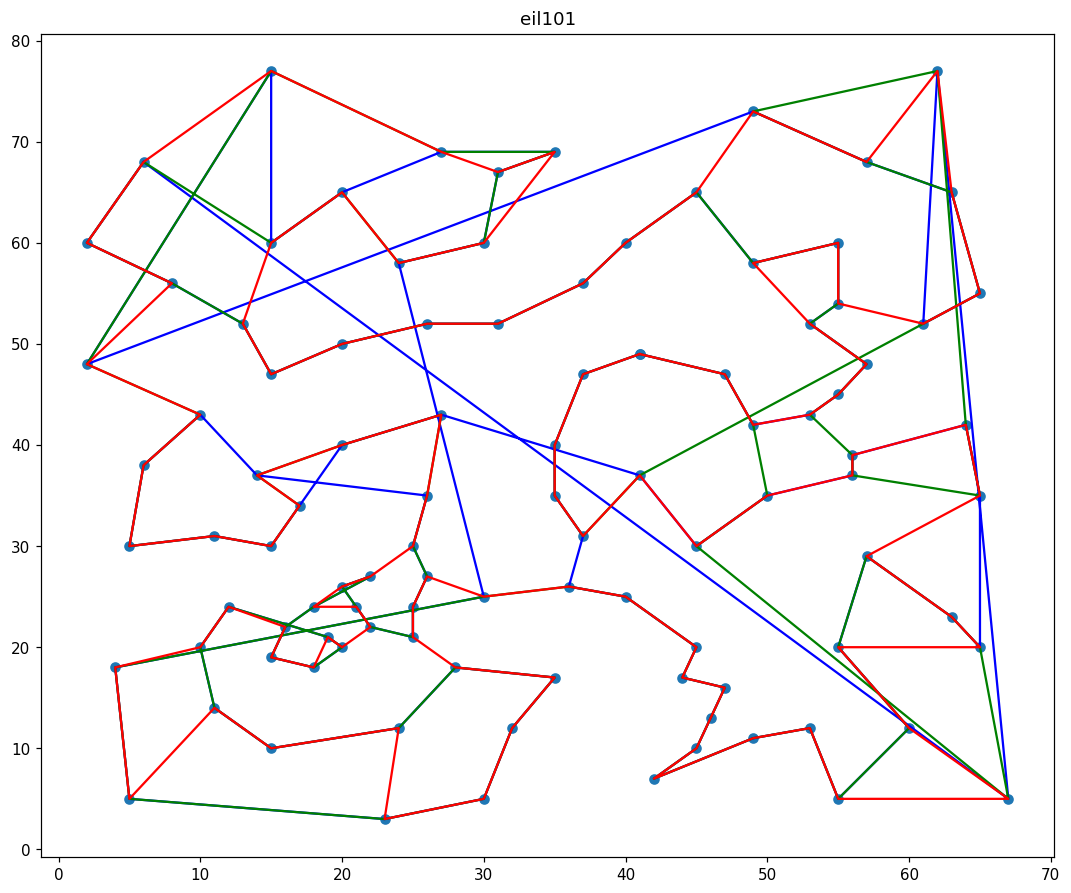

(red)   Optimal  Tour:    629   100.0%
(grn) Minimum NN Tour:    746   118.6%
(blu) Maximum NN Tour:    913   145.2%

  Average Tour Length:    832   132.3%

1 tours of length    746:	[29]
1 tours of length    762:	[54]
2 tours of length    763:	[25, 55]
1 tours of length    764:	[24]
1 tours of length    773:	[39]
1 tours of length    774:	[23]
2 tours of length    777:	[4, 26]
2 tours of length    778:	[67, 80]
1 tours of length    780:	[56]
2 tours of length    784:	[12, 72]
5 tours of length    785:	[22, 33, 53, 75, 76]
2 tours of length    786:	[68, 77]
1 tours of length    787:	[40]
2 tours of length    788:	[21, 73]
2 tours of length    795:	[41, 50]
1 tours of length    803:	[1]
1 tours of length    806:	[44]
3 tours of length    808:	[42, 58, 69]
1 tours of length    809:	[9]
1 tours of length    814:	[2]
1 tours of length    815:	[101]
1 tours of length    819:	[15]
1 tours of length    820:	[20]
1 tours of length    822:	[66]
1 tours of length    823:	[98]
1 tours of length 

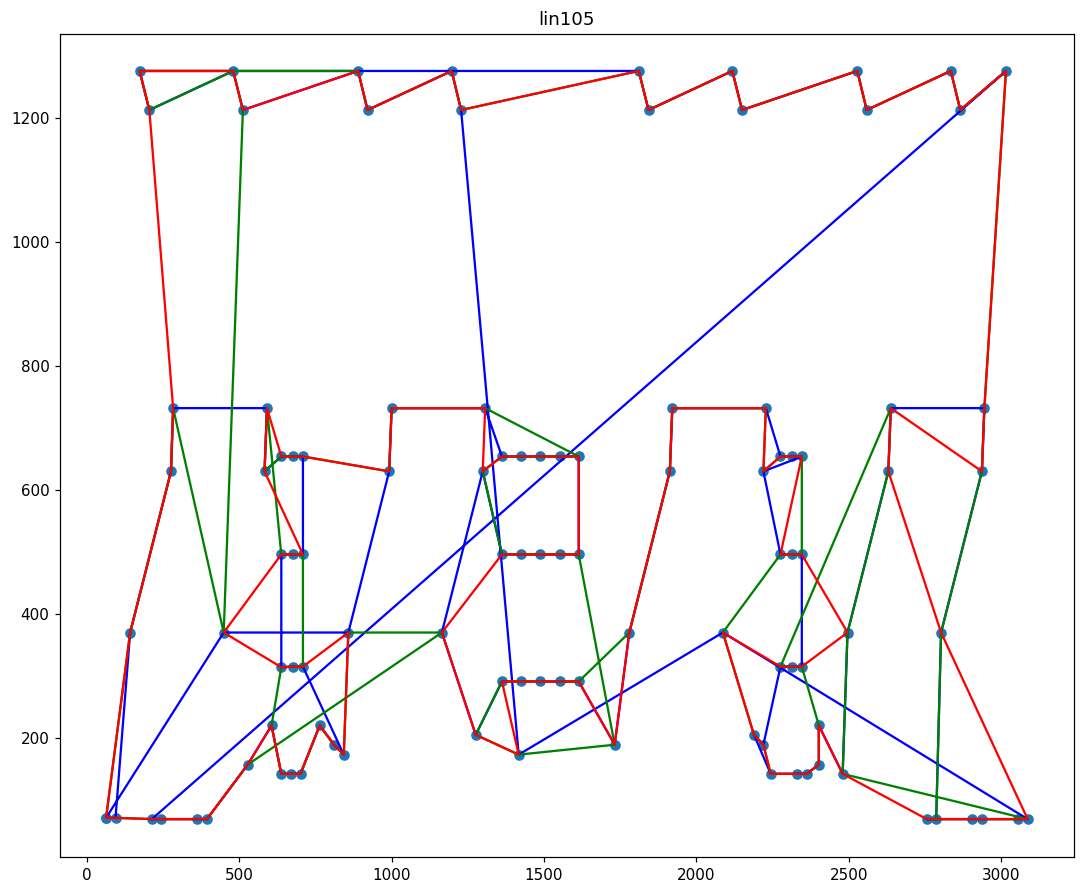

(red)   Optimal  Tour:  14379   100.0%
(grn) Minimum NN Tour:  16935   117.8%
(blu) Maximum NN Tour:  20584   143.2%

  Average Tour Length:  18710   130.1%

1 tours of length  16935:	[72]
1 tours of length  16952:	[73]
2 tours of length  16996:	[64, 67]
1 tours of length  17039:	[80]
1 tours of length  17042:	[76]
1 tours of length  17052:	[59]
1 tours of length  17058:	[68]
1 tours of length  17098:	[79]
1 tours of length  17099:	[77]
1 tours of length  17143:	[71]
1 tours of length  17222:	[85]
1 tours of length  17231:	[83]
1 tours of length  17316:	[78]
1 tours of length  17353:	[102]
2 tours of length  17355:	[97, 101]
1 tours of length  17363:	[96]
1 tours of length  17369:	[82]
1 tours of length  17396:	[63]
1 tours of length  17473:	[84]
1 tours of length  17511:	[49]
1 tours of length  17642:	[99]
1 tours of length  17812:	[86]
1 tours of length  17840:	[62]
1 tours of length  17890:	[88]
1 tours of length  17908:	[87]
1 tours of length  18073:	[39]
1 tours of length  18127:	

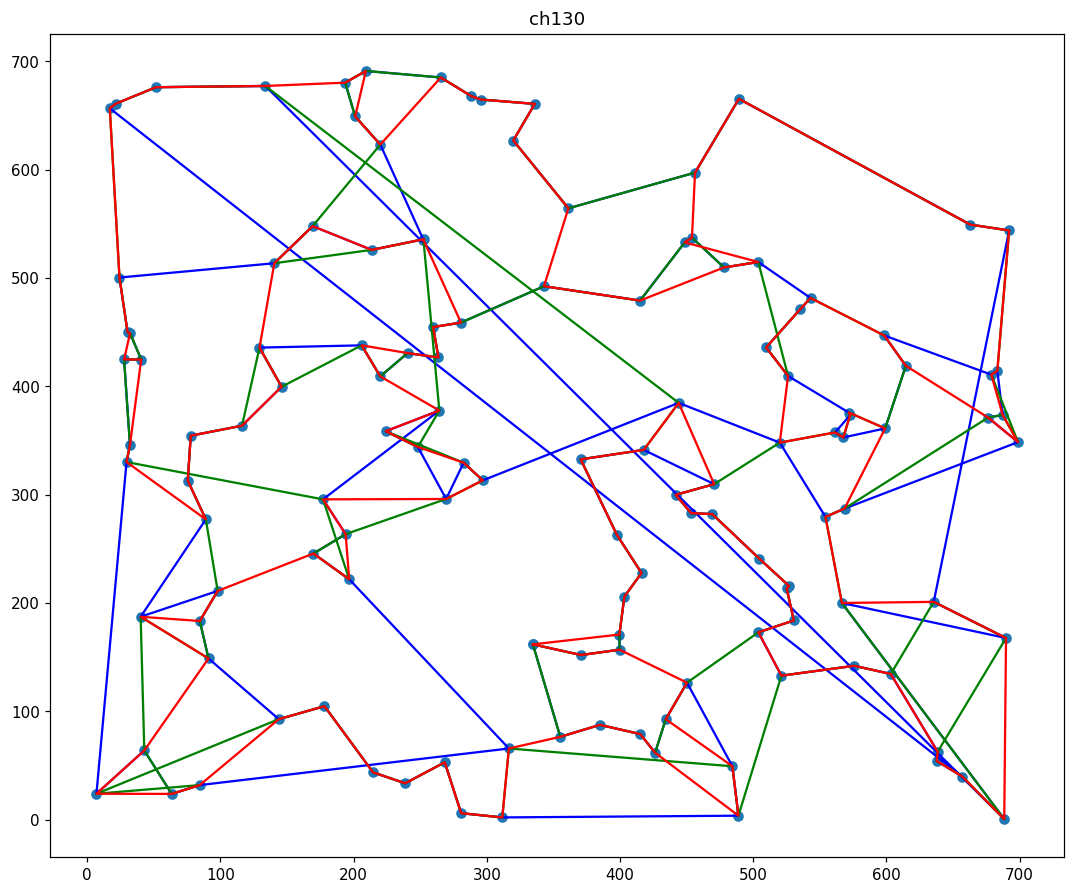

(red)   Optimal  Tour:   6110   100.0%
(grn) Minimum NN Tour:   7129   116.7%
(blu) Maximum NN Tour:   8837   144.6%

  Average Tour Length:   7736   126.6%

1 tours of length   7129:	[4]
1 tours of length   7192:	[103]
1 tours of length   7196:	[77]
1 tours of length   7206:	[54]
1 tours of length   7228:	[99]
1 tours of length   7229:	[73]
1 tours of length   7261:	[74]
1 tours of length   7275:	[78]
1 tours of length   7277:	[75]
1 tours of length   7307:	[126]
1 tours of length   7331:	[35]
1 tours of length   7341:	[12]
1 tours of length   7342:	[87]
1 tours of length   7358:	[8]
1 tours of length   7360:	[114]
1 tours of length   7363:	[108]
1 tours of length   7366:	[81]
1 tours of length   7379:	[111]
1 tours of length   7381:	[123]
1 tours of length   7383:	[65]
2 tours of length   7385:	[82, 101]
1 tours of length   7386:	[57]
1 tours of length   7392:	[9]
1 tours of length   7395:	[30]
1 tours of length   7421:	[20]
1 tours of length   7423:	[118]
1 tours of length   7425:	[

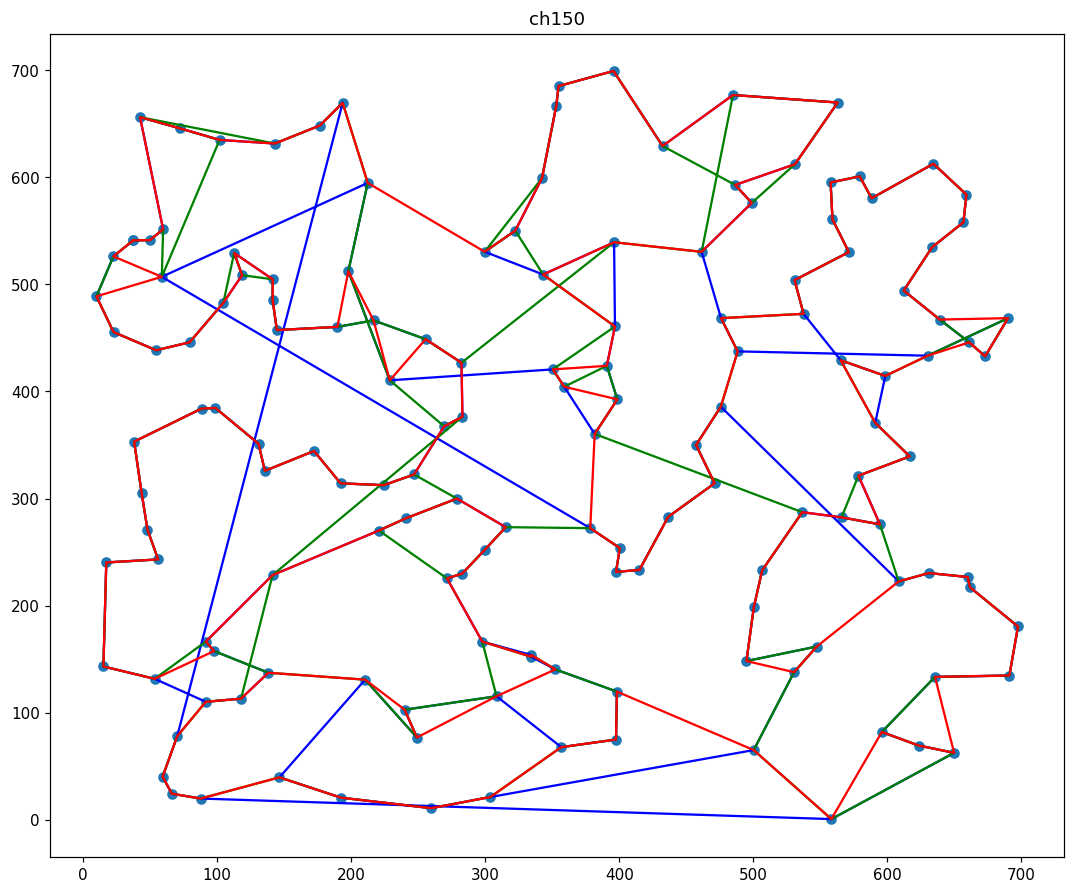

(red)   Optimal  Tour:   6528   100.0%
(grn) Minimum NN Tour:   7113   109.0%
(blu) Maximum NN Tour:   8349   127.9%

  Average Tour Length:   7672   117.5%

1 tours of length   7113:	[71]
3 tours of length   7129:	[13, 91, 128]
3 tours of length   7140:	[22, 113, 125]
1 tours of length   7157:	[10]
1 tours of length   7174:	[116]
1 tours of length   7176:	[68]
1 tours of length   7184:	[119]
1 tours of length   7210:	[149]
1 tours of length   7227:	[145]
2 tours of length   7260:	[82, 95]
1 tours of length   7290:	[43]
1 tours of length   7296:	[136]
1 tours of length   7308:	[51]
3 tours of length   7309:	[5, 107, 124]
1 tours of length   7314:	[112]
1 tours of length   7329:	[74]
1 tours of length   7331:	[109]
1 tours of length   7363:	[32]
1 tours of length   7386:	[44]
1 tours of length   7402:	[123]
1 tours of length   7424:	[104]
1 tours of length   7429:	[39]
1 tours of length   7432:	[106]
1 tours of length   7437:	[33]
1 tours of length   7444:	[90]
2 tours of length   7451:

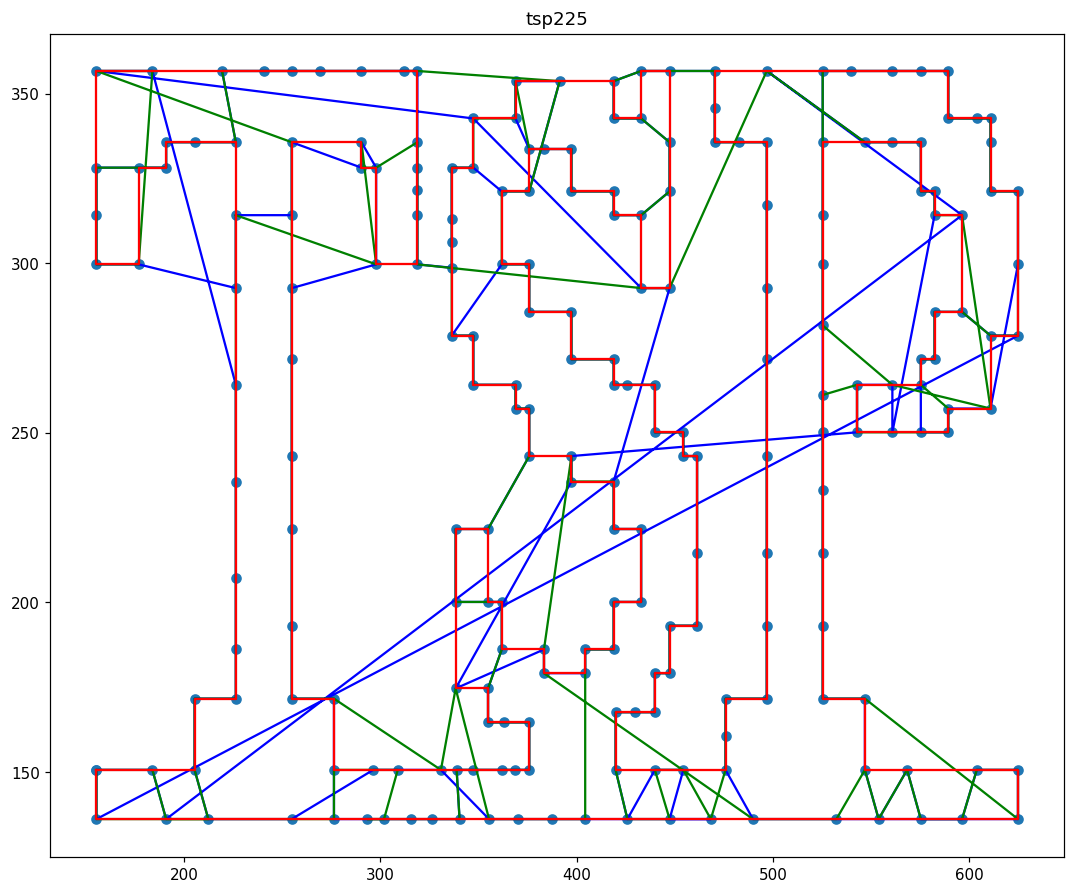

(red)   Optimal  Tour:   3861   100.0%
(grn) Minimum NN Tour:   4557   118.0%
(blu) Maximum NN Tour:   5603   145.1%

  Average Tour Length:   5092   131.9%

1 tours of length   4557:	[12]
1 tours of length   4570:	[16]
1 tours of length   4573:	[22]
1 tours of length   4584:	[18]
1 tours of length   4591:	[17]
1 tours of length   4594:	[21]
1 tours of length   4595:	[91]
1 tours of length   4599:	[92]
1 tours of length   4608:	[15]
1 tours of length   4614:	[20]
2 tours of length   4624:	[203, 210]
2 tours of length   4637:	[88, 90]
1 tours of length   4643:	[19]
1 tours of length   4651:	[89]
1 tours of length   4660:	[95]
1 tours of length   4674:	[32]
1 tours of length   4710:	[31]
1 tours of length   4722:	[1]
1 tours of length   4723:	[5]
1 tours of length   4725:	[7]
1 tours of length   4726:	[4]
1 tours of length   4727:	[35]
1 tours of length   4731:	[200]
2 tours of length   4734:	[70, 217]
1 tours of length   4735:	[77]
1 tours of length   4737:	[63]
1 tours of length   4738

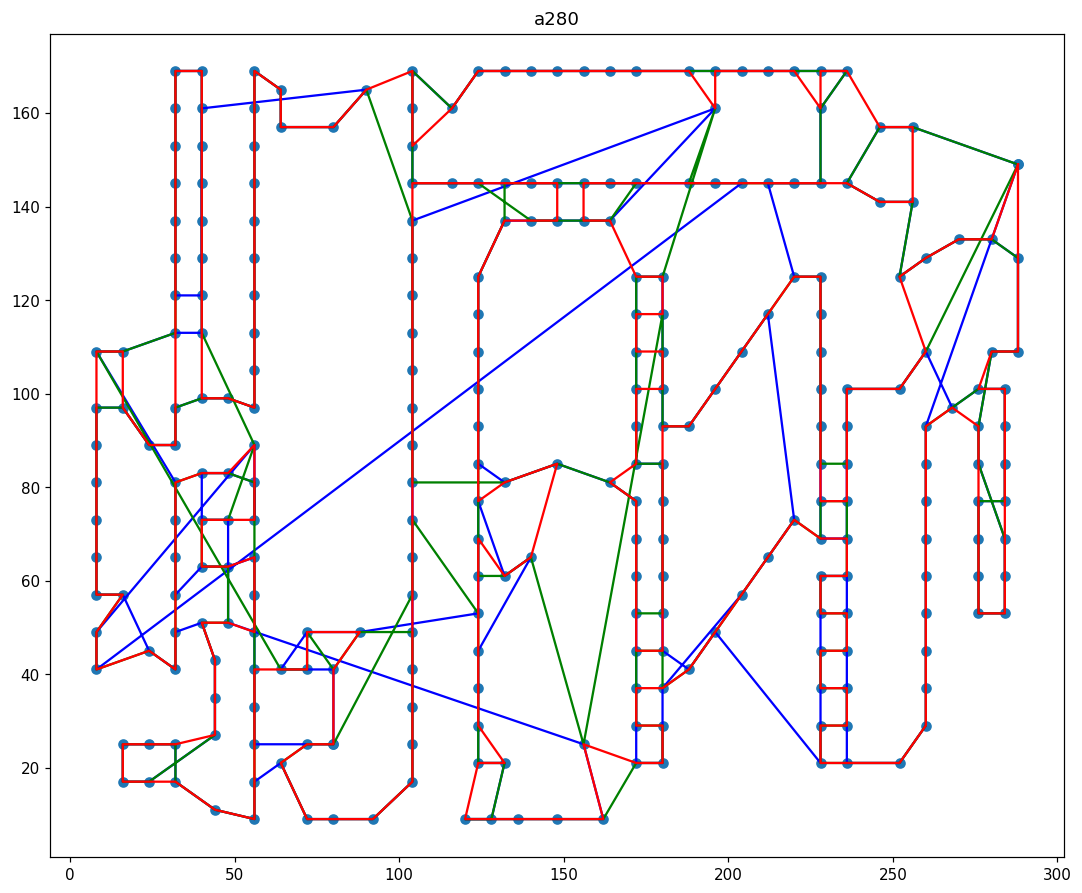

(red)   Optimal  Tour:   2579   100.0%
(grn) Minimum NN Tour:   2975   115.4%
(blu) Maximum NN Tour:   3417   132.5%

  Average Tour Length:   3172   123.0%

1 tours of length   2975:	[179]
1 tours of length   2976:	[186]
1 tours of length   2982:	[184]
1 tours of length   2986:	[190]
1 tours of length   2987:	[185]
1 tours of length   2989:	[189]
2 tours of length   2990:	[191, 192]
2 tours of length   2992:	[178, 187]
2 tours of length   2998:	[163, 164]
1 tours of length   3006:	[165]
2 tours of length   3021:	[162, 175]
1 tours of length   3022:	[153]
1 tours of length   3041:	[193]
1 tours of length   3043:	[160]
1 tours of length   3053:	[159]
1 tours of length   3063:	[158]
2 tours of length   3065:	[168, 221]
1 tours of length   3066:	[217]
1 tours of length   3070:	[213]
1 tours of length   3073:	[220]
2 tours of length   3076:	[207, 216]
1 tours of length   3078:	[188]
2 tours of length   3081:	[144, 212]
7 tours of length   3087:	[134, 135, 136, 137, 139, 209, 257]
2 tours o

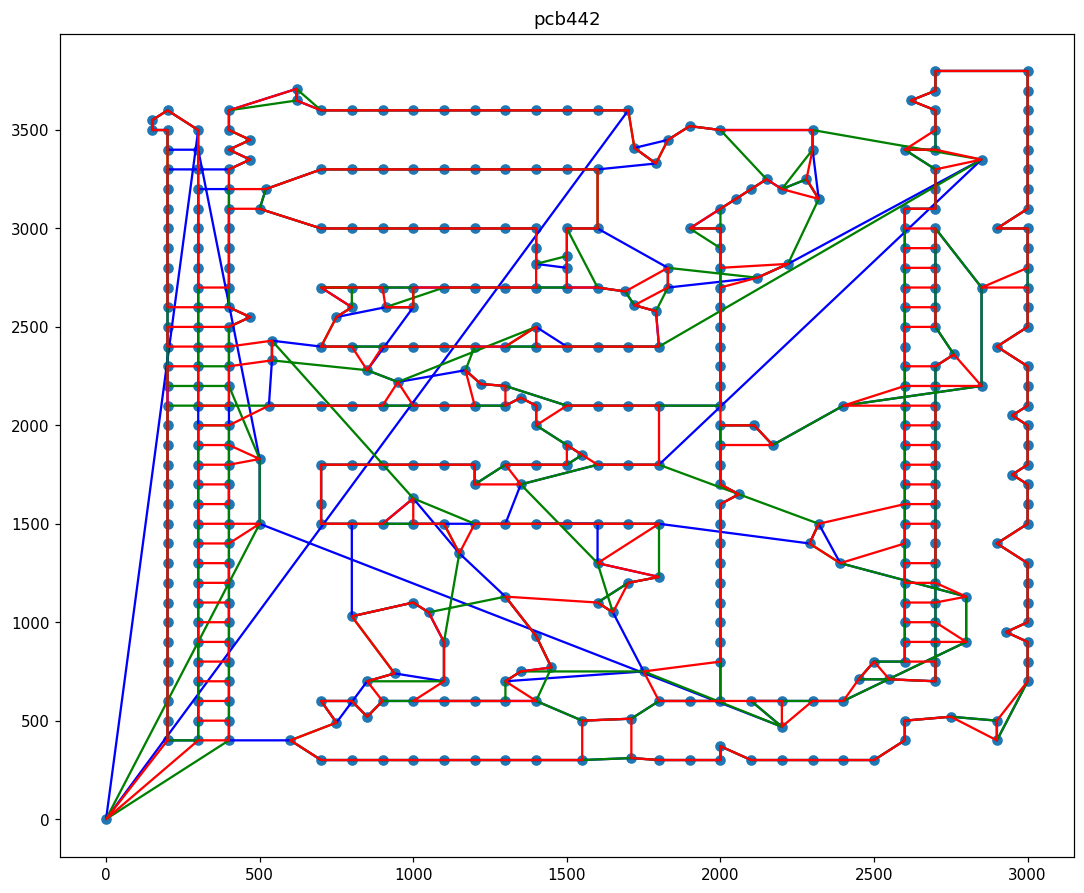

(red)   Optimal  Tour:  50778   100.0%
(grn) Minimum NN Tour:  58950   116.1%
(blu) Maximum NN Tour:  66158   130.3%

  Average Tour Length:  62249   122.6%

1 tours of length  58950:	[396]
1 tours of length  58990:	[173]
1 tours of length  59045:	[162]
1 tours of length  59138:	[151]
1 tours of length  59229:	[405]
1 tours of length  59378:	[178]
1 tours of length  59683:	[108]
1 tours of length  59696:	[165]
1 tours of length  59735:	[7]
1 tours of length  59750:	[8]
1 tours of length  59788:	[177]
1 tours of length  59808:	[9]
1 tours of length  59897:	[231]
1 tours of length  59947:	[10]
1 tours of length  59980:	[74]
1 tours of length  59992:	[75]
1 tours of length  60047:	[76]
1 tours of length  60049:	[43]
1 tours of length  60064:	[44]
1 tours of length  60093:	[99]
1 tours of length  60100:	[311]
2 tours of length  60121:	[45, 310]
1 tours of length  60125:	[250]
1 tours of length  60138:	[15]
1 tours of length  60141:	[415]
1 tours of length  60171:	[312]
1 tours of length  6

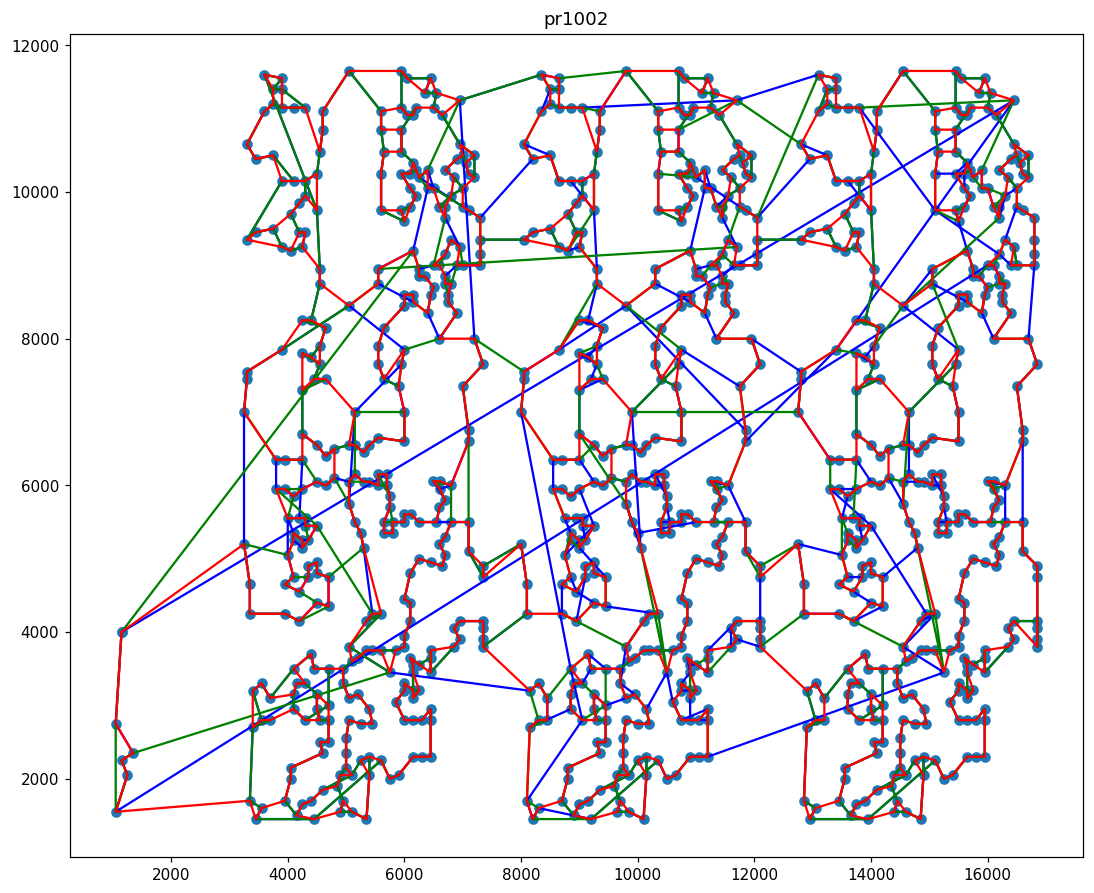

(red)   Optimal  Tour:  259045   100.0%
(grn) Minimum NN Tour:  313745   121.1%
(blu) Maximum NN Tour:  349420   134.9%

  Average Tour Length:  328715   126.9%

1 tours of length  313745:	[243]
1 tours of length  313870:	[621]
1 tours of length  313889:	[622]
1 tours of length  313921:	[131]
1 tours of length  313984:	[141]
1 tours of length  313998:	[140]
1 tours of length  314177:	[275]
1 tours of length  314349:	[138]
1 tours of length  314527:	[187]
1 tours of length  314792:	[90]
1 tours of length  314802:	[169]
1 tours of length  314915:	[92]
1 tours of length  314938:	[133]
1 tours of length  314973:	[246]
1 tours of length  315081:	[145]
1 tours of length  315091:	[237]
1 tours of length  315121:	[168]
1 tours of length  315234:	[95]
1 tours of length  315274:	[91]
1 tours of length  315303:	[165]
1 tours of length  315368:	[99]
1 tours of length  315383:	[150]
1 tours of length  315435:	[810]
1 tours of length  315446:	[98]
1 tours of length  315539:	[152]
1 tours of length  

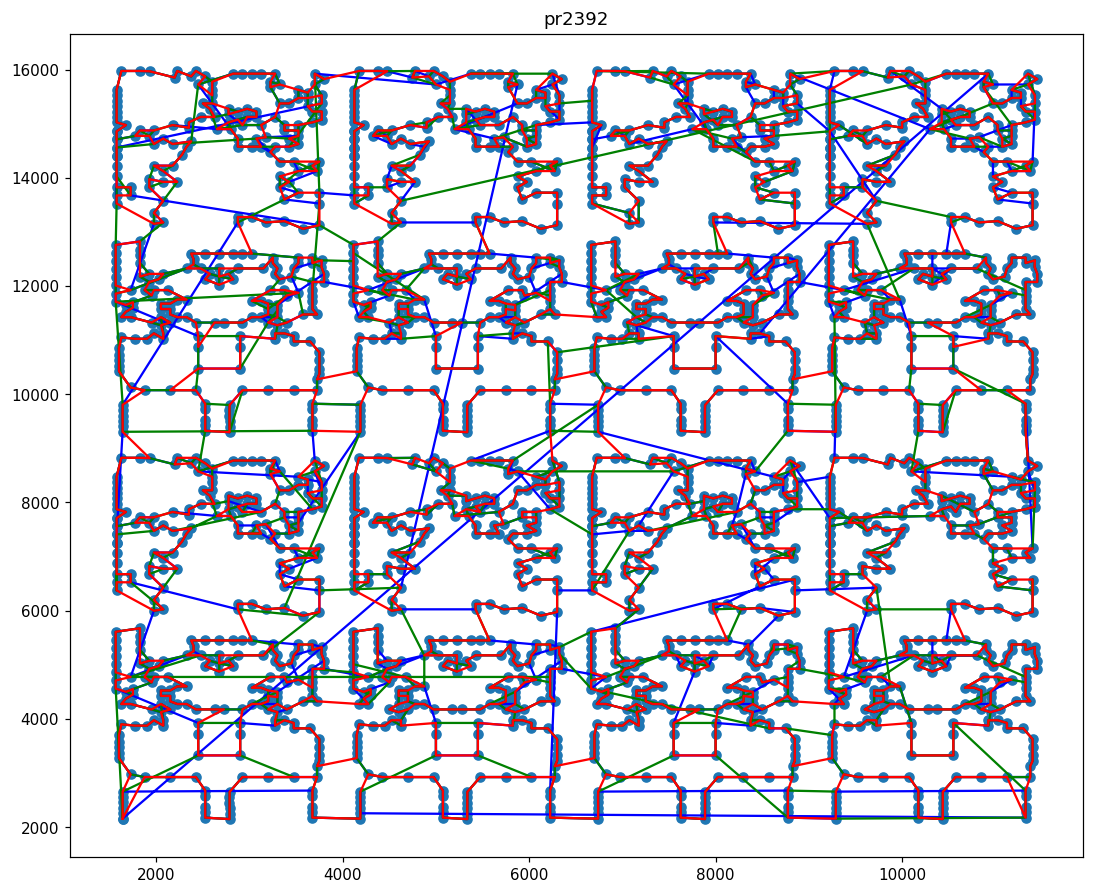

(red)   Optimal  Tour:  378032   100.0%
(grn) Minimum NN Tour:  458745   121.4%
(blu) Maximum NN Tour:  488871   129.3%

  Average Tour Length:  473461   125.2%

1 tours of length  458745:	[149]
1 tours of length  459026:	[148]
1 tours of length  460039:	[166]
1 tours of length  460109:	[164]
1 tours of length  460274:	[2139]
1 tours of length  460312:	[2140]
1 tours of length  460352:	[2141]
1 tours of length  460494:	[2151]
2 tours of length  460642:	[2147, 2148]
1 tours of length  460837:	[2224]
1 tours of length  460908:	[2233]
1 tours of length  460973:	[5]
1 tours of length  461020:	[2235]
1 tours of length  461054:	[2146]
1 tours of length  461084:	[2223]
1 tours of length  461139:	[4]
3 tours of length  461170:	[1, 2391, 2392]
2 tours of length  461181:	[1531, 1580]
1 tours of length  461210:	[2329]
1 tours of length  461220:	[2387]
1 tours of length  461294:	[1581]
1 tours of length  461315:	[9]
1 tours of length  461331:	[2145]
1 tours of length  461382:	[13]
1 tours of lengt

1 tours of length  479259:	[522]
1 tours of length  479267:	[18]
1 tours of length  479277:	[518]
1 tours of length  479282:	[582]
1 tours of length  479296:	[700]
1 tours of length  479319:	[579]
1 tours of length  479325:	[697]
1 tours of length  479326:	[715]
1 tours of length  479328:	[581]
1 tours of length  479330:	[696]
1 tours of length  479348:	[1855]
1 tours of length  479351:	[1856]
1 tours of length  479353:	[936]
1 tours of length  479357:	[583]
1 tours of length  479362:	[531]
1 tours of length  479367:	[1811]
1 tours of length  479373:	[1810]
1 tours of length  479377:	[1815]
2 tours of length  479410:	[749, 791]
2 tours of length  479443:	[578, 1814]
1 tours of length  479446:	[1925]
1 tours of length  479449:	[1591]
1 tours of length  479474:	[635]
1 tours of length  479479:	[726]
1 tours of length  479485:	[733]
1 tours of length  479495:	[1812]
1 tours of length  479507:	[572]
1 tours of length  479514:	[748]
1 tours of length  479517:	[939]
1 tours of length  479535

In [28]:
print( 'Started\n')
showAllNN( '.\\ALL_tsp' )